# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation


### Background 

The following analysis is based on a Kaggle dataset from Criteo, an internet advertising company focused on retargeting. Criteo's goal is to increase online clickthrough rates among consumers who have previously visited an advertiser's website. This information will be used by Criteo to more efficiently provide the right ads to the right people. Optimizing the retargeting process not only helps advertisers become more efficient in terms of how they spend their dollars, but also it reduces clutter for consumers who do not want to be "followed" by ads for irrelevant products (or ones they may have already purchased!).

There are 13 numerical features and 26 categorical features in this dataset. Our goal is to create a model that will most accurately predict clickthroughs (label = 1). It is likely that these features represent characterstics about consumer behavior (history of clickthroughs, site visitiation, etc.), the ads themselves (product, creative approach, placement, etc.) and general metrics such as the date the ad was published. Since there is no visibility into what each feature represents, however, our challenge is to make our predictions based on the data alone. With over 6 million records, this will require a scalable approach.

### Key Questions

* Which machine learning approach not only provides the highest accuracy in predicting clickthroughs, but is also scalable enough to be useful in a production environment? As internet patterns and product choices change rapidly, the ideal model should be updated daily to update the following day's retargeting model.  - Note: not sure I fully answered this piece:  *** Preview what level of performanceyour model would need to achieve to be practically useful ***

* Which features are most important in predicting clickthroughs? Having this information can help Criteo focus on the metrics that are most critical to their product.

* With 39 features, there is a high risk of overfitting. We should identify a model that provides an optimal tradeoff between bias and variance.


## 2. Algorithm Explanation

Given scalability concerns and the need for feature selection, we decided to explore two independent models to assess the optimal performance. We also wanted to identify algorithms that have a history of success in the Spark framework and with binary classification. Logistic Regression and Decision Trees met all of these criteria. Logistic Regession is highly scalable and combined with regularization could aid in feature selection. Decision trees have similar benefits but also require little pre-processing and no direct feature selection. We continued down these parallel paths to compare the performance of these models.

### Data Loading and Pre-Processing

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [6]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


In [7]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [8]:
toyRDD_train, trainRDD2 = trainRDD.randomSplit([0.001,0.999], seed = 2)
toyRDD_test, mainRDD_test = heldOutRDD.randomSplit([0.001,0.999], seed = 2)

In [9]:
#toyRDD_train.take(1)
toyRDD_train.take(1)

['1\t5\t2\t\t\t1382\t17\t78\t25\t76\t0\t9\t\t\t05db9164\t942f9a8d\t56472604\t53a5d493\t25c83c98\t\t49b74ebc\t6c41e35e\ta73ee510\te113fc4b\tc4adf918\t08531bcb\t85dbe138\t1adce6ef\tae97ecc3\t76b06ec3\te5ba7672\t1f868fdd\t9437f62f\ta458ea53\tff4c70b8\t\t32c7478e\tda89b7d5\t7a402766\tc7beb94e']

In [10]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = np.array(line.split('\t'))
    features,label = fields[1:14], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append(np.nan)
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(float(value))
    return (formated_features, label)

In [11]:
#trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()
toyRDD_train1 = toyRDD_train.map(parse).map(edit_data_types)
toyRDD_test2 = toyRDD_test.map(parse).map(edit_data_types)

In [12]:
print(toyRDD_train1.count())
#print(toyRDD_test1.count())

36451


In [13]:
sample = np.array(toyRDD_train1.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13', 'Label'])

In [14]:
columns = (['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13', 'Label'])
#columns = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
sample_numeric = sample_df.reindex(columns=columns)
sample_numeric[columns] = sample_numeric[columns].astype(np.float)

In [15]:
"""Get means and standard deviations. Ideally we should do this in the RDD vs. pandas"""

means = []
stdevs = []

for i in sample_numeric.columns[0:13]:
    mean = np.nanmean(sample_numeric[i])
    means.append(mean)
    std = np.nanstd(sample_numeric[i])
    stdevs.append(std)
        
print(means)
print(stdevs)


[4.164150943396226, 102.271, 17.273936170212767, 6.96516129032258, 17504.025484199796, 96.59664948453609, 19.74367088607595, 12.574574574574575, 104.00316455696202, 0.6679245283018868, 2.919831223628692, 1.2378854625550662, 8.225806451612904]
[9.509351789102883, 322.7148703716641, 31.64668584436759, 8.408602304540327, 65951.30770633514, 201.85445899865584, 76.14245692688245, 13.381227576184473, 221.92516649954453, 0.7543017725786832, 5.536216317193093, 4.336686134602433, 12.056184806628144]


In [16]:
"""Get medians for each class. Ideally we should do this in the RDD vs. pandas"""

median1 = np.array(sample_numeric[sample_numeric['Label'] == 1.0].median().tolist())
print(median1)

median0 = np.array(sample_numeric[sample_numeric['Label'] == 0.0].median().tolist())
print(median0)

[2.000e+00 3.000e+00 5.000e+00 3.000e+00 1.414e+03 1.500e+01 6.000e+00
 6.500e+00 3.200e+01 1.000e+00 2.000e+00 0.000e+00 3.000e+00 1.000e+00]
[1.0000e+00 3.0000e+00 6.0000e+00 4.0000e+00 3.7095e+03 3.8000e+01
 2.0000e+00 8.0000e+00 3.6000e+01 0.0000e+00 1.0000e+00 0.0000e+00
 5.0000e+00 0.0000e+00]


In [17]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = np.array(line.split('\t'))
    features,label = fields[1:14], fields[0]
    return(features, label)

def update_nans(line):
    """
    Replace missing values with meidans for each label    
    """
    
    #median1 = np.array([2.0, 3.5, 4.0, 4.0, 1362.0, 13.5, 8.0, 7.0, 42.5, 1.0, 2.0, 0.0, 3.0, 1.0])
    #median0 = np.array([0.0, 2.0, 7.0, 5.0, 3539.0, 46.5, 2.0, 8.0, 38.5, 0.0, 1.0, 0.0, 5.0, 0.0])
        
    features, label = line[0], float(line[1])
    formated_features = []
    for i, value in enumerate(features):
        if value == '' and label == 1.0:
            formated_features.append(float(median1[i]))
        elif value == '' and label == 0.0:
            formated_features.append(float(median0[i]))
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, label)

In [18]:
toyRDDCached_train = toyRDD_train.map(parse).map(update_nans)
toyRDDCached_test = toyRDD_test.map(parse).map(update_nans)

In [19]:
meanClickthroughs = toyRDDCached_train.values().mean()

In [20]:
meanClickthroughs

0.25475295602315423

In [21]:
toyRDDCached_test.take(1)

[([1.0, 3.0, 5.0, 2.0, 2.0, 0.0, 55.0, 15.0, 23.0, 1.0, 11.0, 0.0, 0.0], 1.0)]

In [ ]:
# this is what I was working on to flatten outliers..


featureMeans = np.array(means)
featureStdev = np.array(stdevs)
upper_bounds = np.array(featureMeans + (featureStdev * 3))
lower_bounds = np.array(featureMeans - (featureStdev * 3))
# print("feature means", featureMeans)
# print("feature std devs", featureStdev)
# print("upper_bounds", upper_bounds)
# print("lower_bounds", lower_bounds)

def flatten_outliers(line):
    features = line[0]
    labels = line[1]
    for i in range(features):
        for j in range(upper_bounds):
            if i > j:
                features[i] = j
    for i in range(features):
        for k in range(lower_bounds):
            if i < k:
                features[i] = k
    return features, labels
            
# testRDD = toyRDDCached_train.mapValues(lambda x: x == ).take(1)
#testRDD.collect()


In [22]:
def standardize(dataRDD):
    """Standardize the data"""

    sc.broadcast(means)
    sc.broadcast(stdevs)
    
    featureMeans = np.array(means)
    featureStdev = np.array(stdevs)
       
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))
    
    return normedRDD

In [23]:
# Normalize both the test and training sets
normedRDD_train = standardize(toyRDDCached_train).cache()
normedRDD_test = standardize(toyRDDCached_test).cache()

In [24]:
normedRDD_train.take(1)

[(array([ 0.08789758, -0.31071081, -0.3878427 , -0.47156009, -0.24445346,
         -0.39432693,  0.76509652,  0.92857142, -0.12618292, -0.88548715,
          1.09825347, -0.28544502, -0.43345441]), 1.0)]

## 3. EDA & Discussion of Challenges

In [ ]:
# Get summary statitics
sample_df.iloc[:,0:21].describe(include = "all")

In [ ]:
# Get summary statistics
sample_df.iloc[:,21:39].describe(include = "all")

In [ ]:
# Take a look at histograms for each feature 
sample_numeric.hist(figsize=(23,15), bins=15)
#sample_numeric[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

In [ ]:
# part b -  plot boxplots of each feature vs. the outcome

fig, ax_grid = plt.subplots(5, 3, figsize=(23,15))
y = sample_df['Label']
for idx, feature in enumerate(FIELDS[0:13]):
    x = sample_numeric[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

In [ ]:
# Look at correrlations across features

corr = sample_numeric[FIELDS[:13]].corr()
fig, ax = plt.subplots(figsize=(15, 13))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features")
plt.show()

## 4. Algorithm Implementation

### Following is a homegrown implementation of Logistic Regression

In [25]:
# Define the baseline model
BASELINE_1 = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
BASELINE_2 = np.array([meanClickthroughs, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [26]:
# Compute log loss for Logisitc Regression
def LRLoss(cachedRDD, W):
    
    augmentedData = cachedRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))

    loss = augmentedData.map(lambda x: -x[1] * np.log(1/ (1 + np.exp(-(np.dot(x[0],W))))) - (1-x[1]) * np.log(1-(1/ (1 + np.exp(-(np.dot(x[0],W))))))).mean()
    
    return loss

In [27]:
#Using meanClickthroughs as our bias term improves loss significantly (it will be used in our baseline)

train_loss_baseline1 = LRLoss(normedRDD_train, BASELINE_1)
print("Train Loss using 0 for baseline", train_loss_baseline1)

train_loss_baseline2 = LRLoss(normedRDD_train, BASELINE_2)
print("Train Loss using meanClickthroughs as baseline", train_loss_baseline2)


Train Loss using 0 for baseline 1.0585087314950672
Train Loss using meanClickthroughs as baseline 0.7637151310692348


In [28]:
BASELINE = np.array([meanClickthroughs, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [29]:
# Compute the gradient for logistic regression (one step)

def GDUpdate(dataRDD, W, learningRate):
    
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
        
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean()

    new_model = W - (learningRate * grad)

    return new_model

In [30]:
# Review Gradient Descent steps
nSteps = 3
model = BASELINE
#learningRate = .1
print(f"BASELINE:  Loss = {LRLoss(normedRDD_train,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD_train, model, .1)
    loss = LRLoss(normedRDD_train, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7637151310692348
----------
STEP: 1
Loss: 0.7449910292499055
Model: [0.224, 0.01, 0.003, 0.001, -0.001, -0.004, -0.005, 0.005, -0.002, 0.001, 0.025, 0.008, 0.008, -0.003]
----------
STEP: 2
Loss: 0.7277617913614016
Model: [0.194, 0.019, 0.005, -0.001, -0.002, -0.008, -0.01, 0.009, -0.004, 0.002, 0.05, 0.015, 0.017, -0.006]
----------
STEP: 3
Loss: 0.7119153299126009
Model: [0.165, 0.027, 0.007, 0.003, -0.003, -0.012, -0.014, 0.013, -0.006, 0.002, 0.073, 0.022, 0.024, -0.008]


In [32]:
# Perform one Gradient Descent update with lasso regularization

def GDUpdate_Lasso(dataRDD, W, learningRate, regParam):

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    #new_model = None    
    wReg = np.sign(W)
    wReg[0] = 0  #set bias to zero
       
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean() + (wReg * regParam)
    new_model = W - (learningRate * grad)
    
    return new_model

In [37]:
new_model = GDUpdate_Lasso(normedRDD_train, BASELINE, .1, .1)
print(new_model)

[ 0.22389365  0.00956181  0.00257687  0.00099639 -0.00086452 -0.00429818
 -0.00505806  0.00486502 -0.00234793  0.000844    0.02535733  0.00779211
  0.00847686 -0.00335935]


In [33]:
# Take a look at a few Gradient Descent steps
nSteps = 5
model = BASELINE
#learningRate = .1
#regParam = .1
print(f"BASELINE:  Loss = {LRLoss(normedRDD_train,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate_Lasso(normedRDD_train, model, .1, .1)
    loss = LRLoss(normedRDD_train, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7637151310692348
----------
STEP: 1
Loss: 0.7449910292499055
Model: [0.224, 0.01, 0.003, 0.001, -0.001, -0.004, -0.005, 0.005, -0.002, 0.001, 0.025, 0.008, 0.008, -0.003]
----------
STEP: 2
Loss: 0.7358405527549117
Model: [0.194, 0.009, -0.005, -0.011, 0.008, 0.002, 0.0, -0.001, 0.006, -0.008, 0.04, 0.005, 0.007, 0.004]
----------
STEP: 3
Loss: 0.7212600800705432
Model: [0.165, 0.007, 0.008, 0.012, -0.003, -0.012, -0.014, 0.014, -0.007, 0.002, 0.054, 0.002, 0.005, -0.01]
----------
STEP: 4
Loss: 0.7121642555729325
Model: [0.137, 0.006, -0.0, -0.006, 0.006, -0.006, -0.009, 0.008, 0.001, -0.007, 0.067, -0.001, 0.002, -0.003]
----------
STEP: 5
Loss: 0.7016324537410166
Model: [0.11, 0.004, 0.012, 0.015, -0.005, -0.0, -0.003, 0.002, -0.011, 0.004, 0.08, 0.017, -0.0, 0.004]


In [45]:
W = new_model
threshold = .55
augmentedData = normedRDD_train.map(lambda x: (np.append([1.0], x[0]), x[1]))
augmentedData.take(5)

def predict_label(line):
    features = line[0]
    label = line[1]
    pred = None
    z = np.dot(features,W)
    prob = np.divide(1.0, (1.0 + np.exp(-z)))
    if prob > threshold:
        pred = float(1.0)
    else:
        pred = float(0.0)
    return z, prob, label, pred

def map_accuracy(line):
    label_actual = line[0]        
    label_pred = line[1]

    if label_actual == 1.0 and label_pred == 1.0:
        return "TP", 1.0
    elif label_actual == 1.0 and label_pred == 0.0:
        return "FN", 1.0
    elif label_actual == 0.0 and label_pred == 0.0:
        return "TN", 1.0
    else:
        if label_actual == 0.0 and label_pred == 1.0:
            return "FP", 1.0

#scores = augmentedData.map(predict_label)
scores = augmentedData.map(predict_label).map(map_accuracy).reduceByKey(lambda x, y: x + y)

In [42]:
def get_scores(dataRDD, W, threshold):
    """Assess peformance of current models"""
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
        
    sc.broadcast(W)
    sc.broadcast(threshold)

    def predict_label(line):
        features = line[0]
        label = line[1]
        pred = None
        z = np.dot(features,W)
        prob = np.divide(1.0, (1.0 + np.exp(-z)))
        if prob > threshold:
            pred = float(1.0)
        else:
            pred = float(0.0)
        return label, pred
        
    def map_accuracy(line):
        label_actual = line[0]        
        label_pred = line[1]
        
        if label_actual == 1.0 and label_pred == 1.0:
            return "TP", 1.0
        elif label_actual == 1.0 and label_pred == 0.0:
            return "FN", 1.0
        elif label_actual == 0.0 and label_pred == 0.0:
            return "TN", 1.0
        else:
            if label_actual == 0.0 and label_pred == 1.0:
                return "FP", 1.0
    
    scores = augmentedData.map(predict_label).map(map_accuracy).reduceByKey(lambda x, y: x + y)
    
    return scores

In [44]:
#new_model = [0.773, 0.006, 0.008, 0.008, 0.005, -0.009, 0.006, 0.005, -0.007, -0.007, 0.105, -0.001, 0.011, -0.011]
# train_scores_test = get_scores(normedRDD_train, new_model, .5).collect()
# print(train_scores)
updated_model = GDUpdate_Lasso(normedRDD_train, BASELINE, .1, .1)

In [46]:
Get_Scores = get_scores(normedRDD_train, updated_model, .55).collect()
Get_Scores

[('FP', 8269.0), ('FN', 1585.0), ('TN', 18896.0), ('TP', 7701.0)]

In [50]:
# Assess performance of current models. Takes "train_scores" as input.

def assess_performance(scores):

    TP, FN, TN, FP = 0.0, 0.0, 0.0, 0.0

    for i in scores:
        if i[0] == 'TP':
            TP = i[1]
        elif i[0] == 'FN':
            FN = i[1]
        elif i[0] == 'TN':
            TN = i[1]
        else:
            if i[0] == 'FP':
                FP = i[1]

    if TP != 0.0:
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = 2*((precision*recall)/(precision+recall))
        accuracy = (TP+TN)/(TP+TN+FP+FN)   
    else:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
        accuracy = 0.0

    print("True Positives=", TP)
    print("False Negatives=", FN)
    print("True Negatives=", TN)
    print("False Positives=", FP)
    print("Precision=", precision)
    print("Recall=", recall)
    print("F1_score=", f1_score)
    print('Accuracy=', accuracy)
    
    return accuracy, precision, recall, accuracy
        

In [53]:
Accuracy =  assess_performance(Get_Scores)
Accuracy

True Positives= 7701.0
False Negatives= 1585.0
True Negatives= 18896.0
False Positives= 8269.0
Precision= 0.4822166562304321
Recall= 0.829312944217101
F1_score= 0.6098352866645549
Accuracy= 0.7296644810841952


(0.7296644810841952, 0.4822166562304321, 0.829312944217101, 0.6098352866645549)

In [66]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        
        model = GDUpdate_Lasso(trainRDD, model, .1, .1)
        training_loss = LRLoss(trainRDD, model)
        test_loss = LRLoss(testRDD, model)
                
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [67]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [80]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(normedRDD_train, normedRDD_test, wInit, nSteps = 30)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 30 iterations in 556.9607865810394 seconds


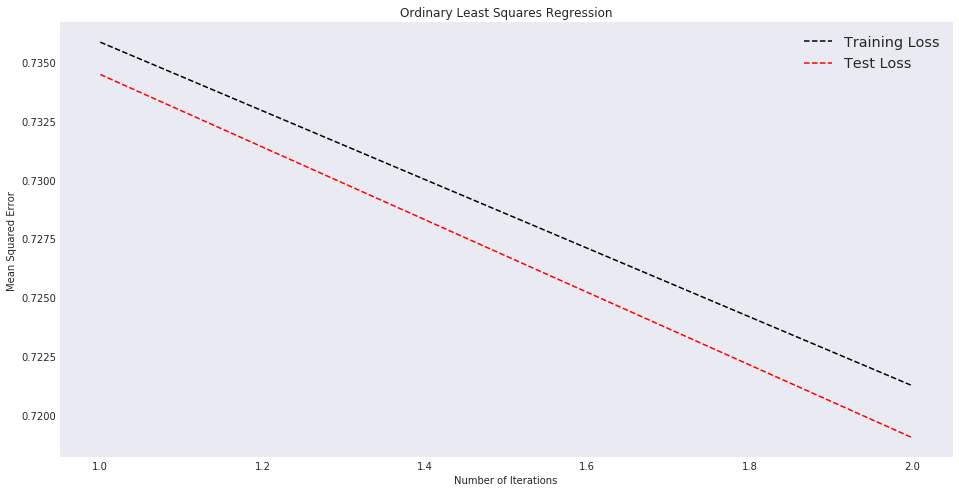

In [72]:
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [75]:
def assessment(trainRDD, new_models, threshold, verbose=True):

    model_list = []
    get_scores = []
    accuracies = []
    f1s = []
    precisions =[]
    recalls = []
    
    for w in new_models:    
        new_scores = get_scores(trainRDD, w, threshold).collect()
        accuracy, precision, recall, f1_score = assess_performance(new_scores)
        model_list.append(w)
        get_scores.append(new_scores)
        accuracies.append(accuracy)
        f1s.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)

    if verbose:
        print("----------")
        print(f"STEP: {idx+1}")
        print(f"training loss: {training_loss}")
        print(f"test loss: {test_loss}")
        print(f"Model: {[round(w,3) for w in model]}")

        
    return model_list, get_scores, accuracies, f1s, precisions, recalls
        
    

In [79]:
assess = assessment(normedRDD_train, models, threshold=.55)


TypeError: 'list' object is not callable

In [57]:
# Run Logistic Regression gradient descent function and capture accuracy for each model
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 10, 
                    learningRate = 0.1, verbose = True):
    """
    Perform nSteps iterations of Logistic Regression gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    
    for idx in range(nSteps): 
        
        new_model = GDUpdate_Lasso(trainRDD, model, .1, .1)
        training_loss = LRLoss(trainRDD, new_model)
        test_loss = LRLoss(testRDD, new_model)
        
        training_scores = get_scores(trainRDD, new_model, .55)
        testing_scores = get_scores(testRDD, new_model, .55)
        
        train_accuracy = assess_performance(training_scores)
        test_accuracy = assess_performance(testing_scores)
        
        model = new_model
        
        # keep track of accuracy for plotting
        train_history.append(train_accuracy)
        test_history.append(test_accuracy)
        model_history.append(model)
        
        # console output 
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training accuracy: {train_accuracy}")
            print(f"test accuracy: {test_accuracy}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [58]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
Train_Loss, Test_Loss, models = GradientDescent(normedRDD_train, normedRDD_test, wInit, nSteps = 3)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

TypeError: 'PipelinedRDD' object is not iterable

In [ ]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(train_Accuracy)))[1:]
    ax.plot(x, train_Accuracy[1:], 'k--', label='Training Accuracy')
    ax.plot(x, test_Accuracy[1:], 'r--', label='Test Accuracy')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    if title:
        plt.title(title)
    plt.show()

## 5. Application of Course Concepts